In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import altair as alt

In [2]:
fn = "/Users/elischwat/Downloads/250917_for_Eli/230517_120045.nc"

# Open a subset of one large file

In [3]:
ds = xr.open_dataset(fn, chunks="auto")  # Lazily opens the NetCDF file with Dask

# Get a slice so we just do a bit of processing
ds = ds.sel(frame=slice(0, 10)).compute()


In [4]:
# Let's just use 1 frame
ds_1frame = ds['irdata'].sel(frame=0)

In [5]:
# the data is "shifted" in the col axis.. we need to chop and concatenate. 
# This col value where the shift happens varies with frame...
# we will only deal with one frame for now.
right_side = ds_1frame.sel(col = slice(0,868))
left_side  = ds_1frame.sel(col = slice(869, 1024))
ds_1frame = xr.concat(
    [left_side, right_side],
    dim='col'
)

# Transpoe and then reverse rows so that it plots in a visually-spatially-correct way
ds_1frame = ds_1frame.T
ds_1frame = ds_1frame[::-1,::]

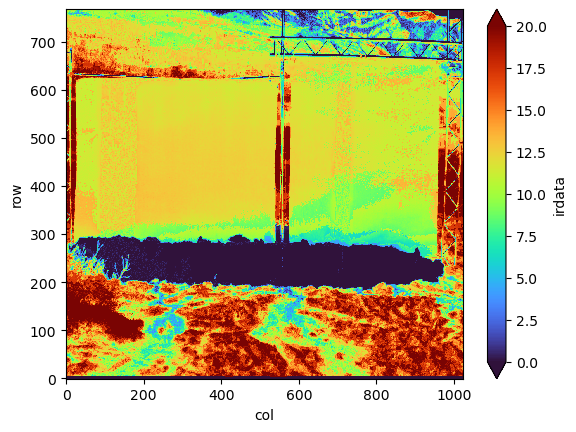

In [6]:
ds_1frame.plot(vmin=0,vmax=20, cmap='turbo')

find the "ground" - where the left pole "ends"

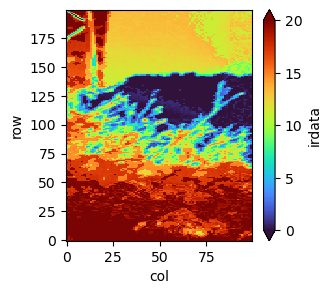

In [7]:
ds_1frame.sel(
    row=slice(150,350),
    col=slice(0, 100),
).plot(vmin=0,vmax=20, cmap='turbo', figsize=(3,3))

Looks like its at about row=125. We will grab all data above that 

In [8]:
ds_1frame_cropped = ds_1frame.sel(row=slice(275,ds_1frame.row.values.max()))

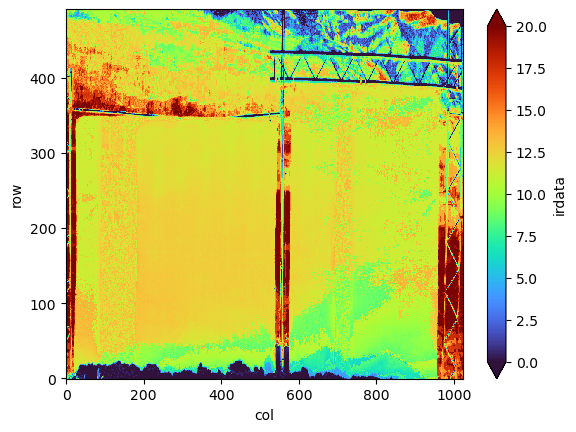

In [9]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Grab a subset of the data so col starts at and ends at the left and right boundaries of the two sheets.

In [10]:
# this removes the left most edge
ds_1frame_cropped = ds_1frame_cropped.sel(col=slice(28,1024))

# this removes the right most edge
ds_1frame_cropped = ds_1frame_cropped.sel(col=slice(0, 929))

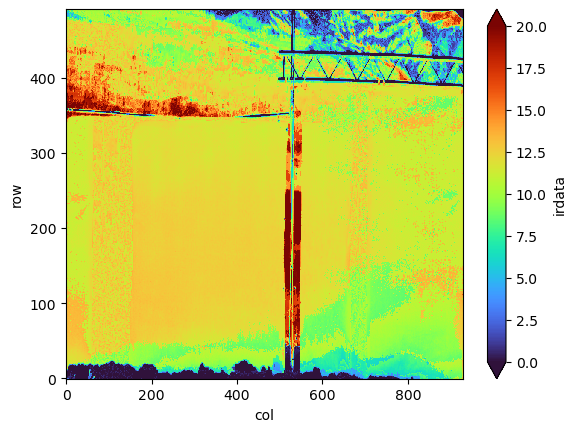

In [11]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Now let's cut off the top

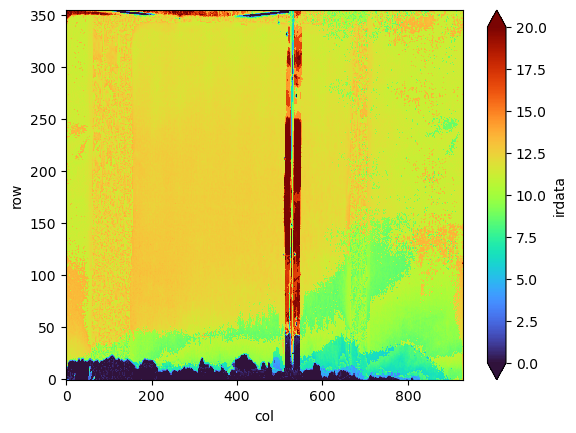

In [12]:
ds_1frame_cropped.sel(
    row = slice(0,355)
).plot(vmin=0,vmax=20, cmap='turbo')

In [13]:
ds_1frame_cropped = ds_1frame_cropped.sel(
    row = slice(0,355)
)

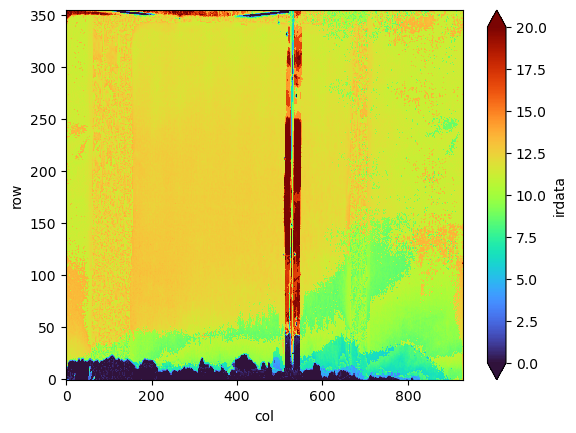

In [14]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Convert the row and column indices to meters

Length relations: 
* the fixation of the left horizontal bar at the leftmost vertical bar is at 1.90m above the (bare) surface. 
* The left horizontal bar from vertical post to vertical post is 2.92m long. 
* The right horizontal bar from vertical post to vertical post is 2.06m. The bottom of the right horizontal bar is 2.26m above bare ground at the middle vertical post. Sorry, a lot of numbers...

i.e...
* total width of the col dimension, i.e. from the left edge of left sheet to right edge of right sheet is: 2.06 + 2.92 = **4.98 meters**
* total height of the row dimension, i.e. from where the pole meets the ground to the top support pole, is **1.9 meters**

In [15]:
TOTAL_WIDTH = 4.98
TOTAL_HEIGHT = 1.9

## FOR THE GRIDDED DATA
# create coords x and why, scaling the col and row dimensions using the dimensions of the observations/sheets
ds_1frame_cropped = ds_1frame_cropped.assign_coords(
    x = TOTAL_WIDTH * ds_1frame_cropped.col / len(ds_1frame_cropped.col),
    z = TOTAL_HEIGHT * ds_1frame_cropped.row / len(ds_1frame_cropped.row)
)

# replace the dims with the physical ones
ds_1frame_cropped = ds_1frame_cropped.to_dataframe().reset_index(drop=True).set_index(['x', 'z']).to_xarray().irdata.T

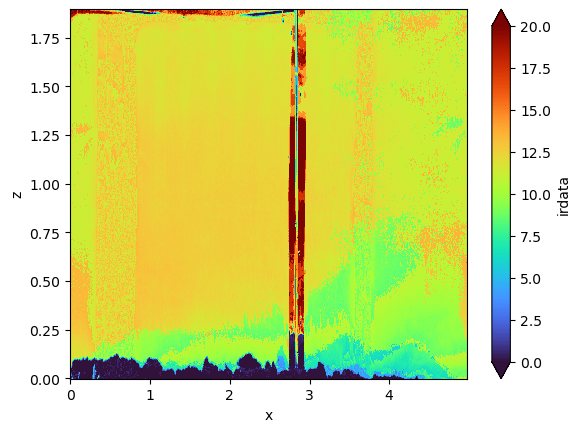

In [16]:
ds_1frame_cropped.plot(vmin=0,vmax=20, cmap='turbo')

Extract Profiles at 50cm intervals, use 10cm width, 2cm height, bins to get values

In [17]:
# get a dataframe for easy processing
df = ds_1frame_cropped.to_dataframe().reset_index()

# bin the z values
df = df.assign(
    z = pd.cut(df['z'], np.linspace(-0.02,2,102)).apply(
        lambda interval: interval.right
    )
)

Combine the datasets. Also, reindex into a higher resolution so that we can manipulate the data later.

In [18]:
z_high_res = np.linspace(0, 2, num=1001)  # Adjust num for desired resolution
z_high_res

array([0.   , 0.002, 0.004, ..., 1.996, 1.998, 2.   ])

In [19]:
df_profiles = pd.concat([
    df.query("x >= 0.45").query("x <= 0.55").groupby('z', observed=True)[['irdata']].mean().assign(x = 0.5).reindex(z_high_res).interpolate(method='linear'),
    df.query("x >= 0.95").query("x <= 1.05").groupby('z', observed=True)[['irdata']].mean().assign(x = 1.0).reindex(z_high_res).interpolate(method='linear'),
    df.query("x >= 1.45").query("x <= 1.55").groupby('z', observed=True)[['irdata']].mean().assign(x = 1.5).reindex(z_high_res).interpolate(method='linear'),
    df.query("x >= 1.95").query("x <= 2.05").groupby('z', observed=True)[['irdata']].mean().assign(x = 2.0).reindex(z_high_res).interpolate(method='linear'),
    df.query("x >= 2.45").query("x <= 2.55").groupby('z', observed=True)[['irdata']].mean().assign(x = 2.5).reindex(z_high_res).interpolate(method='linear'),
    df.query("x >= 2.95").query("x <= 3.05").groupby('z', observed=True)[['irdata']].mean().assign(x = 3.0).reindex(z_high_res).interpolate(method='linear'),
    df.query("x >= 3.45").query("x <= 3.55").groupby('z', observed=True)[['irdata']].mean().assign(x = 3.5).reindex(z_high_res).interpolate(method='linear'),
    df.query("x >= 3.95").query("x <= 4.05").groupby('z', observed=True)[['irdata']].mean().assign(x = 4.0).reindex(z_high_res).interpolate(method='linear'),
])

In [20]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [21]:
src = df_profiles.reset_index().query("x < 3.5")
alt.Chart(
    src
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

In [22]:
src = df_profiles.reset_index().query("x < 3.5").query("z < 0.14")
alt.Chart(
    src
).mark_line(point=True).encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

I need to adjust the profiles for the variable snow surface. 

Steps:
1. (Optional) Interpolate along the lines to get a higher resolution dataset
2. Find z value where irdata = 0 - actually, it looks like things will work better if I use irdata = 2?
3. Adjust z values for that profile

In [23]:
adjusted_df_list = []
for x in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]:
    src = df_profiles.query(f"x == {x}")
    idx = (src['irdata'] - 0).abs().idxmin()
    src.index = src.index - idx + 0
    adjusted_df_list.append(src)
df_adjusted = pd.concat(adjusted_df_list)

In [24]:
src = df_adjusted.reset_index().query("x < 3.5").query("z < 0.14")
alt.Chart(
    src
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    # alt.Facet('x:O', columns=4),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

In [25]:
src = df_adjusted.reset_index()
alt.Chart(
    src
).mark_line().encode(
    alt.X('irdata:Q'),
    alt.Y('z:Q'),
    alt.Color('x:O'),
    order='z:Q',
    tooltip='x'
).properties(width = 300, height = 300)

alt.Chart(...)

$$ < H_O > = H_u + \frac{\Delta S}{X} $$

where $H_u$ is the heat flux upwind of the snow-patch, $\Delta$ S is the *difference in horizontal transport of heat* between the upwind and downwind edges of the snow-patch, and $X$ is the length of the snow-patch.

$$ \Delta S = U_s T(z)_s - U_u T(z)_u$$

In [26]:
combined = df_adjusted.query("x == 3.5")[['irdata']].join(
     df_adjusted.query("x == 0.5")['irdata'].rename('irdata_u')
).dropna()
mean_temp_diff = (combined['irdata'] - combined['irdata_u']).mean()

In [27]:
U = 3 #m/s
X = 3.5
Delta_S = U * mean_temp_diff
Delta_S

-4.097991123819737

In [28]:
from sublimpy import utils
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_q7_flags9000_pf10.parquet"
sos_df = pd.read_parquet(sos_tidy_fn)
sos_df['time'] = pd.to_datetime(sos_df['time'])
sos_df = utils.modify_df_timezone(sos_df, 'UTC', 'US/Mountain')

In [29]:
alt.Chart(
    sos_df[sos_df.variable.isin(
        ['w_tc__3m_c', 'w_tc__3m_d', 'w_tc__3m_ue', 'w_tc__3m_uw']
    )].set_index(
    'time'
).loc['20230517'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N')
)

alt.Chart(...)

In [30]:
alt.Chart(
    sos_df[sos_df.variable.isin(
        ['spd_3m_c', 'spd_3m_d', 'spd_3m_ue', 'spd_3m_uw']
    )].set_index(
    'time'
).loc['20230517'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('tower:N')
)

alt.Chart(...)

In [31]:
H_u = sos_df.query("variable == 'w_tc__3m_uw'").set_index('time').loc['20230517 1200'].value

In [32]:
H_0 = H_u + Delta_S/X
H_0

-1.004109591724073

In [33]:
from metpy.units import units

In [34]:
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude

In [35]:
w_tc_to_watts(H_0)

-1004.6116465199351